In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras import Sequential, layers
from tqdm import tqdm

In [5]:
def format_image(image, label):
    image = tf.image.resize(image, (224,224))/255.0
    return image, label

(train_raw, valid_raw, test_raw), metadata = tfds.load(
    'rock_paper_scissors', split=['train[:80%]','train[80%:]','test'],
    with_info=True, as_supervised=True
)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = train_raw.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
valid_batches = valid_raw.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_raw.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

In [102]:
tf.keras.backend.clear_session()
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

# feature_extractor = hub.KerasLayer(MODULE_HANDLE,
#                                    input_shape=IMAGE_SIZE + (3,), 
#                                    output_shape=[FV_SIZE],
#                                    trainable=False)

feature_extractor = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/3", output_shape=[1280], trainable=False),
  layers.Dense(num_classes, activation='softmax')
])

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=valid_batches)


Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Epoch 1/4
63/63 [==============================] - 6s 46ms/step - loss: 0.8916 - accuracy: 0.5754 - val_loss: 0.7882 - val_accuracy: 0.6806
Epoch 2/4
63/63 [==============================] - 2s 38ms/step - loss: 0.7678 - accuracy: 0.6567 - val_loss: 0.7388 - val_accuracy: 0.6845
Epoch 3/4
63/63 [==============================] - 2s 40ms/step - loss: 0.7275 - accuracy: 0.6607 - val_loss: 0.7059 - val_accuracy: 0.6885
Epoch 4/4
63/63 [==============================] - 3s 40ms/step - loss: 0.6981 - accuracy: 0.6672 - val_loss: 0.6813 - val_accuracy: 0.6528


In [103]:
model.summary()
rock_paper_model = 'exp_model_rock'
tf.saved_model.save(model, rock_paper_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 3)                 2261827   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 12        
Total params: 2,261,839
Trainable params: 3,855
Non-trainable params: 2,257,984
_________________________________________________________________
INFO:tensorflow:Assets written to: exp_model_rock\assets


INFO:tensorflow:Assets written to: exp_model_rock\assets


In [104]:
# Generate converter to tfLite
converter = tf.lite.TFLiteConverter.from_saved_model(rock_paper_model)
tflite_model = converter.convert()

tflite_dir = pathlib.Path('tmp/rock_model.tflite')
tflite_dir.write_bytes(tflite_model)


8883224

In [105]:
# Load tflite model
# Allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors
input = interpreter.get_input_details()[0]['index']
output = interpreter.get_output_details()[0]['index']
print(input, output)

0 181


In [106]:
predictions = []

test_labels, test_images = [],[]
num=100
for img, label in tqdm(test_batches.take(num)):
    interpreter.set_tensor(input, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output))
    test_labels.append(label.numpy()[0])
    test_images.append(img)

score = 0

for item in range(0,num-1):
    pred = np.argmax(predictions[item])
    label = test_labels[item]

    if pred ==label:
        score=score+1

print(f'out of {num} predictions I got {score} correct')

100%|██████████| 100/100 [00:01<00:00, 59.92it/s]

out of 100 predictions I got 41 correct


In [94]:
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

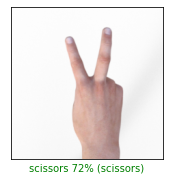

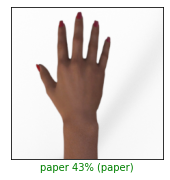

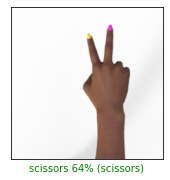

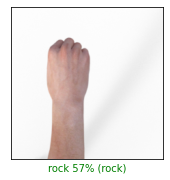

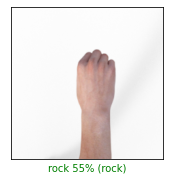

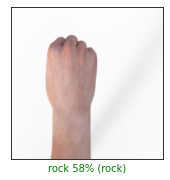

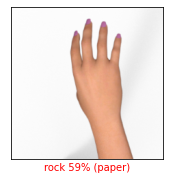

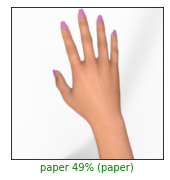

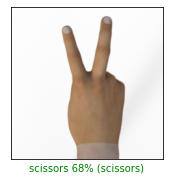

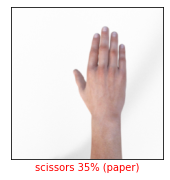

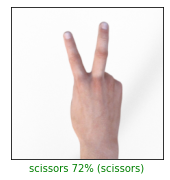

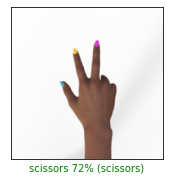

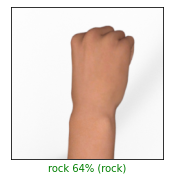

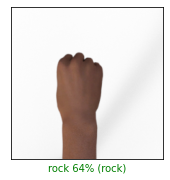

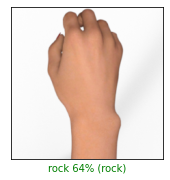

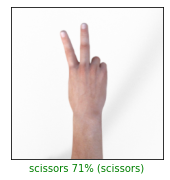

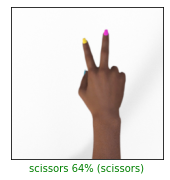

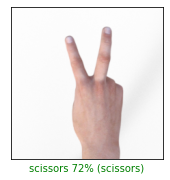

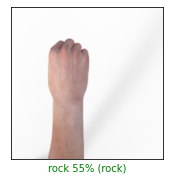

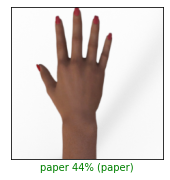

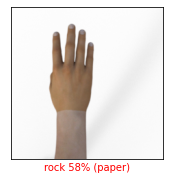

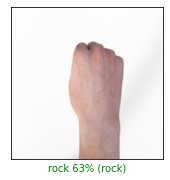

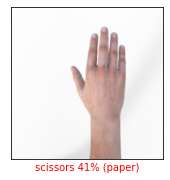

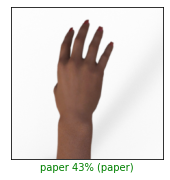

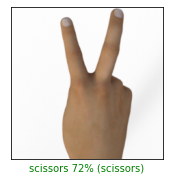

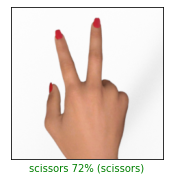

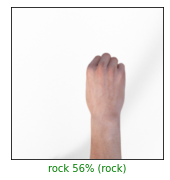

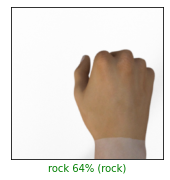

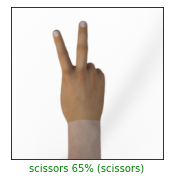

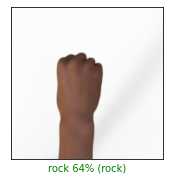

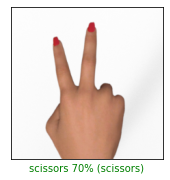

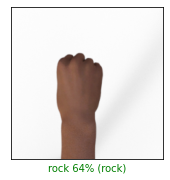

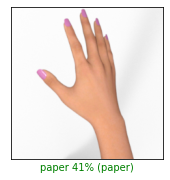

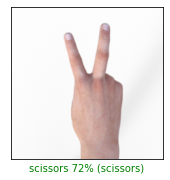

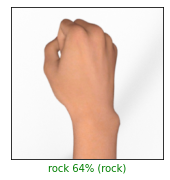

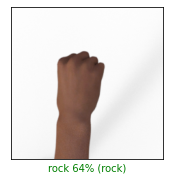

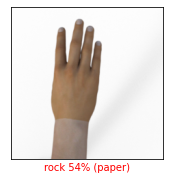

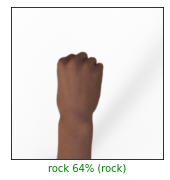

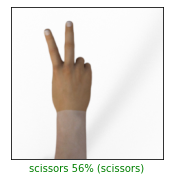

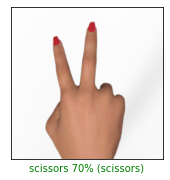

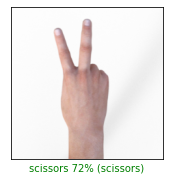

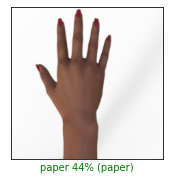

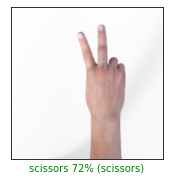

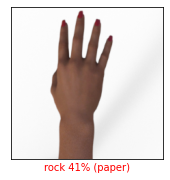

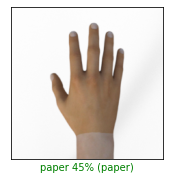

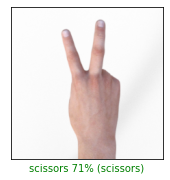

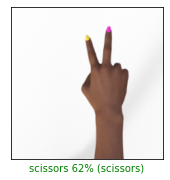

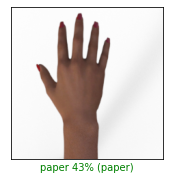

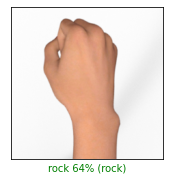

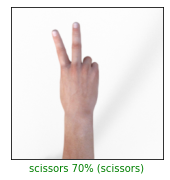

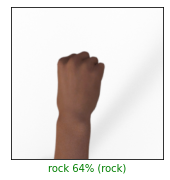

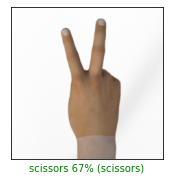

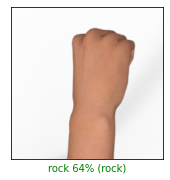

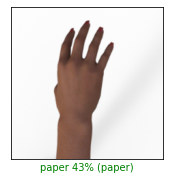

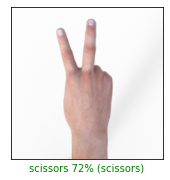

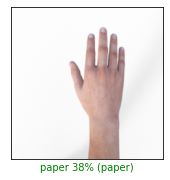

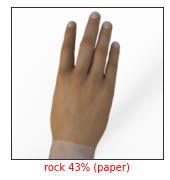

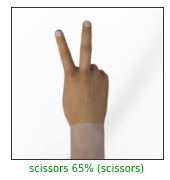

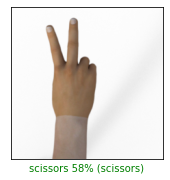

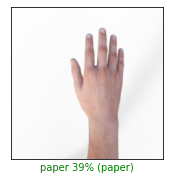

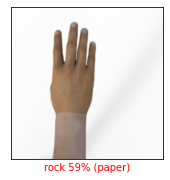

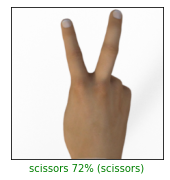

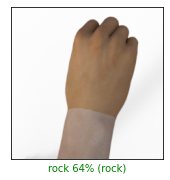

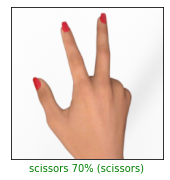

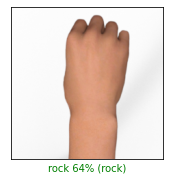

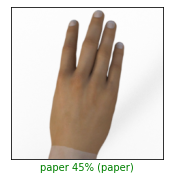

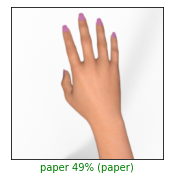

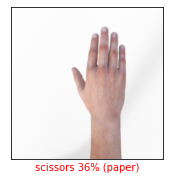

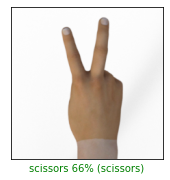

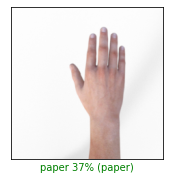

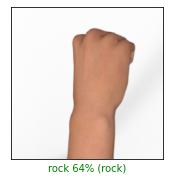

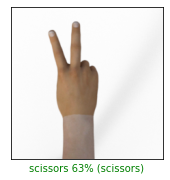

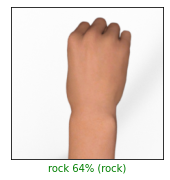

In [64]:
#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_images)
  plt.show()